In [1]:
import numpy as np
import pygeos

from shapely.geometry import LineString
from shapely.ops import polygonize, linemerge

from scipy.spatial import Voronoi

In [2]:
# helper functions
def get_ids(x, ids):
    return ids[x]
mp = np.vectorize(get_ids, excluded=['ids'])

def dist(p1, p2):
    return np.sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))

def get_verts(x, voronoi_diagram):
    return voronoi_diagram.vertices[x]

In [3]:
def average_pygeos(top, bottom, distance=2):
    """
    Returns average geometry.

    top, bottom : LineStrings connected at endpoints
    distance : distance for interpolation

    this version uses pygeos for interpolation and generation of the pre-final geometry
    """
    start = top.coords[0]
    end = top.coords[-1]
    lines = [top, bottom]

    # get an additional line around the lines to avoid infinity issues with Voronoi
    poly = list(polygonize(lines))[0]
    extended_lines = [poly.buffer(distance).exterior] + lines

    # interpolate lines to represent them as points for Voronoi
    points = np.empty((0, 2))
    ids = []

    pygeos_lines = pygeos.from_shapely(extended_lines)
    lengths = pygeos.length(pygeos_lines)
    for ix, (line, length) in enumerate(zip(pygeos_lines, lengths)):
        pts = pygeos.line_interpolate_point(line, 
            np.linspace(0, length, num=int(length//distance))
            )
        points = np.append(points, pygeos.get_coordinates(pts), axis=0)
        ids += [ix] * len(pts)

    # generate Voronoi diagram
    voronoi_diagram = Voronoi(points)

    # get all rigdes and filter only those between the two lines
    pts = voronoi_diagram.ridge_points
    mapped = mp(pts, ids=ids)

    mask = np.isin(mapped[:, 0], [1, 2]) & np.isin(mapped[:, 1], [1, 2]) & (mapped[:, 0] != mapped[:, 1])
    rigde_vertices = np.array(voronoi_diagram.ridge_vertices)
    verts = rigde_vertices[mask]

    # generate the line in between the lines
    edgeline = pygeos.line_merge(pygeos.multilinestrings(get_verts(verts, voronoi_diagram)))

    # snap the endpoints
    coords = pygeos.get_coordinates(edgeline)
    if dist(coords[0], start) > dist(coords[0], end):
        coords[0] = end
        coords[-1] = start
    else:
        coords[0] = start
        coords[-1] = end

    # generate the final linestring
    average = LineString(coords)
    return average

In [4]:
def average_shapely(top, bottom, distance=2):
    """
    Returns average geometry.

    top, bottom : LineStrings connected at endpoints
    distance : distance for interpolation

    this version uses shapely for interpolation and generation of the pre-final geometry
    """
    start = top.coords[0]
    end = top.coords[-1]
    lines = [top, bottom]

    # get an additional line around the lines to avoid infinity issues with Voronoi
    poly = list(polygonize(lines))[0]
    extended_lines = [poly.buffer(distance).exterior] + lines

    # interpolate lines to represent them as points for Voronoi
    points = []
    ids = []

    for ix, line in enumerate(extended_lines):
        current_dist = distance
        line_length = line.length

        while current_dist < line_length:
            points.append(list(line.interpolate(current_dist).coords)[0])
            ids.append(ix)
            current_dist += distance

    # generate Voronoi diagram
    voronoi_diagram = Voronoi(points)

    # get all rigdes and filter only those between the two lines
    pts = voronoi_diagram.ridge_points
    mapped = mp(pts, ids=ids)

    mask = np.isin(mapped[:, 0], [1, 2]) & np.isin(mapped[:, 1], [1, 2]) & (mapped[:, 0] != mapped[:, 1])
    rigde_vertices = np.array(voronoi_diagram.ridge_vertices)
    verts = rigde_vertices[mask]

    # generate the line in between the lines
    edgeline = linemerge(
        [
            LineString([voronoi_diagram.vertices[f], voronoi_diagram.vertices[l]])
            for f, l in verts
        ]
    )

    # snap the endpoints
    coords = list(edgeline.coords)
    if dist(coords[0], start) > dist(coords[0], end):
        coords[0] = end
        coords[-1] = start
    else:
        coords[0] = start
        coords[-1] = end

    # generate the final linestring
    average = LineString(coords)
    return average

In [5]:
import geopandas as gpd

realdf = gpd.read_file('/Users/martin/Dropbox/Python/Jupyter/edges.geojson').to_crs(5514)

top = realdf.loc[0, 'geometry']
bottom = realdf.loc[1, 'geometry']

In [6]:
top.length

2975.599146488999

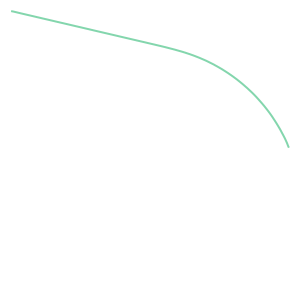

In [7]:
pygeos_line = average_pygeos(top, bottom)
pygeos_line

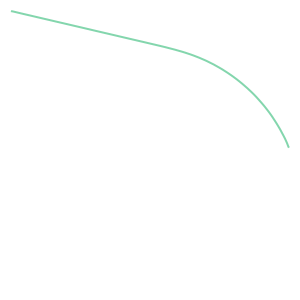

In [8]:
shapely_line = average_shapely(top, bottom)
shapely_line

In [17]:
%%timeit
average_pygeos(top, bottom)

3.43 ms ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
average_shapely(top, bottom)

8.29 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
